<a href="https://colab.research.google.com/github/MKolaksazov/Data-Science/blob/main/Tukey_test_letters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drawing a 'BOXPLOT' graph

Includes letters, showing the significant differences between variants, derived by the means of the Tukey's test.

1) importing of the libraries and the csv file

In [ ]:
import pandas as pd
import numpy as np
# exp_0726_OJIP_p
df = pd.read_csv("/content/exp_0726_OJIP_p_2.csv", delimiter='\t', decimal=',') # delimiter '\t' or ';'

In [ ]:
names = df.pop('groups')
dff = df.T
named = np.array(names)
dff

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
Bckg,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,...,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02,4.220000e+02
Fo,1.219200e+04,8.973000e+03,9.493000e+03,1.020900e+04,1.144400e+04,1.092400e+04,9.038000e+03,1.144400e+04,1.303700e+04,1.163900e+04,...,1.225700e+04,9.818000e+03,8.616000e+03,6.892000e+03,8.323000e+03,6.892000e+03,8.225000e+03,1.033900e+04,1.375200e+04,1.082600e+04
Fj,2.913000e+04,2.113200e+04,2.337600e+04,2.503400e+04,2.854500e+04,2.753700e+04,2.155500e+04,3.039800e+04,3.400700e+04,3.043000e+04,...,3.260900e+04,2.610600e+04,2.214000e+04,1.648300e+04,1.914900e+04,1.719800e+04,2.178300e+04,2.734200e+04,3.794000e+04,2.701700e+04
Fi,3.995600e+04,3.134100e+04,3.231600e+04,3.781000e+04,4.151700e+04,4.145200e+04,2.935800e+04,5.146500e+04,5.712200e+04,5.130300e+04,...,5.900800e+04,4.733600e+04,3.563200e+04,2.665900e+04,2.955300e+04,2.828500e+04,3.729000e+04,4.632800e+04,6.580200e+04,4.652300e+04
Fm,4.990500e+04,4.327200e+04,4.333700e+04,4.808400e+04,5.435900e+04,5.205000e+04,4.070400e+04,5.949500e+04,6.544500e+04,5.858500e+04,...,6.850100e+04,5.474900e+04,4.229700e+04,3.501400e+04,3.771300e+04,3.439700e+04,4.418300e+04,5.468400e+04,7.666100e+04,5.517100e+04
Fv,3.771300e+04,3.429900e+04,3.384400e+04,3.787500e+04,4.291500e+04,4.112600e+04,3.166600e+04,4.805100e+04,5.240800e+04,4.694600e+04,...,5.624400e+04,4.493100e+04,3.368100e+04,2.812200e+04,2.939000e+04,2.750500e+04,3.595800e+04,4.434500e+04,6.290900e+04,4.434500e+04
Vj,4.490000e-01,3.550000e-01,4.100000e-01,3.910000e-01,3.980000e-01,4.040000e-01,3.950000e-01,3.940000e-01,4.000000e-01,4.000000e-01,...,3.620000e-01,3.630000e-01,4.020000e-01,3.410000e-01,3.680000e-01,3.750000e-01,3.770000e-01,3.830000e-01,3.840000e-01,3.650000e-01
Vi,7.360000e-01,6.520000e-01,6.740000e-01,7.290000e-01,7.010000e-01,7.420000e-01,6.420000e-01,8.330000e-01,8.410000e-01,8.450000e-01,...,8.310000e-01,8.350000e-01,8.020000e-01,7.030000e-01,7.220000e-01,7.780000e-01,8.080000e-01,8.120000e-01,8.270000e-01,8.050000e-01
Fm/Fo,4.093000e+00,4.822000e+00,4.565000e+00,4.710000e+00,4.750000e+00,4.765000e+00,4.504000e+00,5.199000e+00,5.020000e+00,5.034000e+00,...,5.589000e+00,5.576000e+00,4.909000e+00,5.080000e+00,4.531000e+00,4.991000e+00,5.372000e+00,5.289000e+00,5.575000e+00,5.096000e+00
Fv/Fo,3.093000e+00,3.822000e+00,3.565000e+00,3.710000e+00,3.750000e+00,3.765000e+00,3.504000e+00,4.199000e+00,4.020000e+00,4.034000e+00,...,4.589000e+00,4.576000e+00,3.909000e+00,4.080000e+00,3.531000e+00,3.991000e+00,4.372000e+00,4.289000e+00,4.575000e+00,4.096000e+00


In [ ]:
import re
for i in range(len(names)):
    c = names[i][0]
    names[i] = re.sub(r'[A-Z]([a-z]+ )', c + '. ', names[i])
names

<ipython-input-76-1b67ac715072>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  names[i] = re.sub(r'[A-Z]([a-z]+ )', c + '. ', names[i])


0     N3
1     N3
2     N3
3     N3
4     N3
5     N3
6     N3
7     N6
8     N6
9     N6
10    N6
11    N6
12    N6
13    N6
14    N6
15    N7
16    N7
17    N7
18    N7
19    N7
20    N7
21    N9
22    N9
23    N9
24    N9
25    N9
26    N9
27    N9
28    N8
29    N8
30    N8
31    N8
32    N8
33    N7
34    N7
35    N7
36    N7
37    N7
38    N7
39    N7
40    N6
41    N6
42    N6
43    N6
44    N6
45    N6
46    N6
Name: groups, dtype: object

In [ ]:
params = df.pop('Pi_Abs') #required param
dff = params.T

#dff = np.array(params)

In [ ]:
from matplotlib.patches import namedtuple
#convert dataframe to matrix
conv_arr= dff.values

#split matrix into 3 columns each into 1d array

#converting into 1D array
arr = conv_arr.ravel()

print(arr)

# variants as well:
print(names)

[1.436 2.981 2.249 2.292 2.243 2.317 2.242 3.011 2.769 2.822 1.034 1.941
 3.347 4.331 4.156 3.91  4.123 3.81  2.845 2.711 3.726 3.177 3.365 3.748
 4.036 3.288 3.474 3.558 1.568 1.945 0.895 1.779 1.567 2.944 3.771 3.781
 2.87  3.999 4.136 2.822 4.169 2.932 3.547 3.928 3.355 3.184 3.477]
0     N3
1     N3
2     N3
3     N3
4     N3
5     N3
6     N3
7     N6
8     N6
9     N6
10    N6
11    N6
12    N6
13    N6
14    N6
15    N7
16    N7
17    N7
18    N7
19    N7
20    N7
21    N9
22    N9
23    N9
24    N9
25    N9
26    N9
27    N9
28    N8
29    N8
30    N8
31    N8
32    N8
33    N7
34    N7
35    N7
36    N7
37    N7
38    N7
39    N7
40    N6
41    N6
42    N6
43    N6
44    N6
45    N6
46    N6
Name: groups, dtype: object


2) arranging the data by samples column-wise and taking out the names of the variants in a different array

Converting the 2-D pandas dataframe into a 1-D numpy array. ```numpy.append(array1, array2) ``` can be used to append two arrays.

Probably ```pandas.dataframe.pop()``` can be used as well.

In [ ]:
# Sample data (replace this with your data)
data = pd.DataFrame({
    'Variant': names,
    'Value': arr
})

3) performing the co-variance test
(the following is a variant, showing the t-test)
(currently not shown)

4) This is a very simple code, showing a Tukey's test analysis and printing the summarized data

In [ ]:
import statsmodels.stats.multicomp as mc

# Perform one-way ANOVA to check for significant differences
model = mc.MultiComparison(data['Value'], data['Variant'])
result = model.tukeyhsd()

print(result.summary(), len(result.reject))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    N3     N6   0.9488 0.0166  0.1261  1.7714   True
    N3     N7   1.2446 0.0012   0.402  2.0871   True
    N3     N8  -0.7006 0.3345 -1.7529  0.3517  False
    N3     N9   1.2694 0.0044  0.3088  2.2301   True
    N6     N7   0.2958 0.7296 -0.3852  0.9768  False
    N6     N8  -1.6494 0.0001 -2.5775 -0.7213   True
    N6     N9   0.3207 0.7999  -0.502  1.1433  False
    N7     N8  -1.9452    0.0 -2.8909 -0.9995   True
    N7     N9   0.0249    1.0 -0.8177  0.8674  False
    N8     N9   1.9701    0.0  0.9177  3.0224   True
---------------------------------------------------- 10


In [ ]:
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
# define columns for data and then grouping
col_to_group='Variant'
col_for_data='Value'

#Now take teh data and regroup for anova
samples = [cols[1] for cols in data.groupby('Variant')['Value']]
#I am not sure how this works but it makes an numpy array for each group
f_val, p_val = stats.f_oneway(*samples)
# I am not sure what this star does but this passes all the numpy arrays correctly

# this if statement can be uncommmented if you don't won't to go furhter with out p<0.05
#if p_val<0.05:    #If the p value is less than 0.05 it then does the tukey
mod = mc.MultiComparison(data['Value'], data['Variant'])
thsd=mod.tukeyhsd()

#this is a function to do Piepho method.
#AN Alogrithm for a letter based representation of al-pairwise comparisons.
tot=len(thsd.groupsunique)
#make an empty dataframe that is a square matrix of size of the groups. #set first column to 1
df_ltr=pd.DataFrame(np.nan, index=np.arange(tot),columns=np.arange(tot))
df_ltr.iloc[:,0]=1
count=0
df_nms = pd.DataFrame('', index=np.arange(tot), columns=['names'])
# I make a dummy dataframe to put axis labels into.  sd stands for signifcant difference

for i in np.arange(tot):   #I loop through and make all pairwise comparisons.
    for j in np.arange(i+1,tot):
        #print('i=',i,'j=',j,thsd.reject[count])
        if thsd.reject[count]==True:
            for cn in np.arange(tot):
                if df_ltr.iloc[i,cn]==1 and df_ltr.iloc[j,cn]==1:
                  #If the column contains both i and j shift and duplicat
                    df_ltr=pd.concat([df_ltr.iloc[:,:cn+1],df_ltr.iloc[:,cn+1:].T.shift().T],axis=1)
                    df_ltr.iloc[:,cn+1]=df_ltr.iloc[:,cn]
                    df_ltr.iloc[i,cn]=0
                    df_ltr.iloc[j,cn+1]=0
                #Now we need to check all columns for abosortpion.
                for cleft in np.arange(len(df_ltr.columns)-1):
                    for cright in np.arange(cleft+1,len(df_ltr.columns)):
                        if (df_ltr.iloc[:,cleft].isna()).all()==False and (df_ltr.iloc[:,cright].isna()).all()==False:
                            if (df_ltr.iloc[:,cleft]>=df_ltr.iloc[:,cright]).all()==True:
                                df_ltr.iloc[:,cright]=0
                                df_ltr=pd.concat([df_ltr.iloc[:,:cright],df_ltr.iloc[:,cright:].T.shift(-1).T],axis=1)
                            if (df_ltr.iloc[:,cleft]<=df_ltr.iloc[:,cright]).all()==True:
                                df_ltr.iloc[:,cleft]=0
                                df_ltr=pd.concat([df_ltr.iloc[:,:cleft],df_ltr.iloc[:,cleft:].T.shift(-1).T],axis=1)

        count+=1

#I sort so that the first column becomes A
df_ltr=df_ltr.sort_values(by=list(df_ltr.columns),axis=1,ascending=False)

# I assign letters to each column
for cn in np.arange(len(df_ltr.columns)):
    df_ltr.iloc[:,cn]=df_ltr.iloc[:,cn].replace(1,chr(97+cn))
    df_ltr.iloc[:,cn]=df_ltr.iloc[:,cn].replace(0,'')
    df_ltr.iloc[:,cn]=df_ltr.iloc[:,cn].replace(np.nan,'')

#I put all the letters into one string
df_ltr=df_ltr.astype(str)
df_ltr.sum(axis=1)


<ipython-input-82-492812fa1dee>:21: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ltr.iloc[:,0]=1
<ipython-input-82-492812fa1dee>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ltr.iloc[:,cn+1]=df_ltr.iloc[:,cn]
<ipython-input-82-492812fa1dee>:34: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_ltr.iloc[:,cn

0    a
1    b
2    b
3    a
4    b
dtype: object

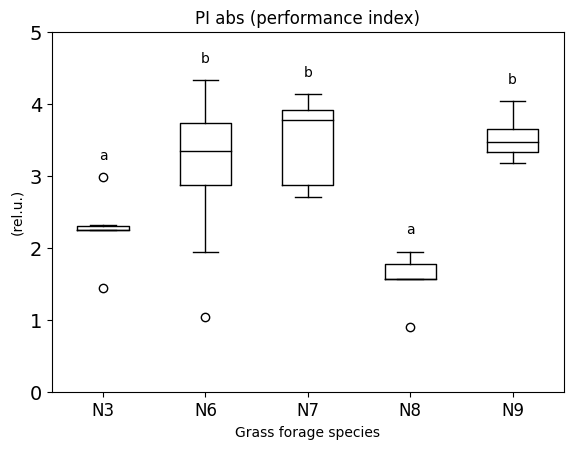

In [ ]:

#Now to plot like R with a violing plot
fig,ax=plt.subplots()
data.boxplot(column=col_for_data, by=col_to_group,ax=ax,fontsize=14, color='black')

#,showmeans=True
#,boxprops=dict(linewidth=2.0),whiskerprops=dict(linewidth=2.0))  #This makes the boxplot

grps=pd.unique(data[col_to_group].values)   #Finds the group names
grps.sort() # This is critical!  Puts the groups in alphabeical order to make it match the plotting

#props=dict(facecolor='white',alpha=1)
''''''
for i,grp in enumerate(grps):   #I loop through the groups to make the scatters and figure out the axis labels.
    y_pos = data[data['Variant'] == grp]['Value'].max() + 0.4
    #y_pos = ax.get_ylim()[1]*1
    ax.text(i+1,y_pos,df_ltr.sum(axis=1)[i],rotation=0,fontsize=10,verticalalignment='top',horizontalalignment='center')

ax.set_xticklabels(grps,rotation=0,fontsize=12)
#ax.set_xticks()
ax.set_ylim([0, 5])
ax.set(title='PI abs (performance index)', ylabel=r'(rel.u.)', xlabel="Grass forage species")
fig.suptitle('')

# PI $_{ABS}$ (performance index)
#

# CO$_2$ uptake (A$_{n}$)
# r'$\mu$mol m$^{-2}$s$^{-1}$ CO$_2$'

# Concentration of chlorophyll (CCi)
# $\mu$mol m$^{-2}$ chl

# TAC - water extracts
# mM AAE g${^-1}$

# PI $_{ABS}$
# (a.u.)

plt.grid(False)
#fig.savefig('anovatest.jpg',dpi=600,bbox_inches='tight')